# DeepDreaming with TensorFlow

>[Loading and displaying the model graph](#loading)

>[Classifying Images](#classify)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualzations](#playing)

>[DeepDream](#deepdream)

>[More Fun!](#fun)


# This tutorial will show how to work with TensorFlow, and how to use image classification models. 
You will benefit most from this if you have some working knowledge of python, and if you have a rough idea what a neural network is and how it works. 

You will learn about deep neural networks, in particular convolutional neural networks, and how they are used for image classification tasks. We will also gain 
an intuitive understanding how neural network represent information they have learned.

Specifically, you will learn how to:

- Load and a pre-trained TensorFlow model and inspect it.
- Classify images using TensorFlow using a pre-trained model.
- Visualize feature channels from a convolutional network to understand what it has learned.
- Enhance what the network sees in a given image to produce dream-like images.

The network we'll examine is [Inception-v3](http://arxiv.org/abs/1512.00567). It's trained to classify an image into 1 of the 1000 categories from the [ImageNet](http://image-net.org/) dataset. For a good introduction to neural networks, see the book [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) by Michael Nielsen. For background on convolutional networks, see Chris Olah's excellent [blog post](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/).

As discussed in [Inceptionism: Going Deeper into Neural Networks](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html), our goal is to visualize the internal image representations learned by a network trained to classify images. We'll make these visualizations both efficient to generate, and even beautiful.

Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) architectures.

In [1]:
# boilerplate code
import os
import re
from cStringIO import StringIO
import numpy as np
from functools import partial
import PIL.Image
import PIL.ImageOps
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

print "Done"

Done


*Note: If you are using getting an import error with PIL, you will need to install Pillow, via:*

```
sudo pip install Pillow
```

*This is required of the current Docker image as well.*

<a id='loading'></a>
## Loading and displaying the model graph

The pretrained network can be downloaded [here](http://download.tensorflow.org/models/inception5h.zip). If it is not already here, download it and unpack the archive. The actual network is stored in the file `tensorflow_inception_graph.pb`. Set the `model_fn` variable to its path.

We will now load the network and prepare it for input. TensorFlow maintains a computation graph and a session, which maintains state for running computations and which can be executed remotely. We will first make a fresh graph and a session which uses that graph. The session will be used in the rest of the tutorial.

We then load the model. The model consists of a computation graph which happens to have a node called "input", into which we need to feed a batch of input images. The input node in the graph expects images that are normalized by subtracting the average brightness of all images in the imagenet dataset. 

Because we will use single, unnormalized images, we will make a small graph that takes an image, subtracts the imagenet mean, and expands it to look like a batch of images. 

We then load the graph from file and import it into the default graph for our session. The little importer graph is now connected to the input node in the loaded graph, and we can feed regular images into the graph.

In [2]:
# creating fresh Graph and TensorFlow session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# Prepare input for the format expected by the graph
t_input = tf.placeholder(np.float32, name='our_input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)

# Load graph and import into graph used by our session
model_fn = 'imagenet/tensorflow_inception_graph.pb'
graph_def = tf.GraphDef.FromString(open(model_fn).read())
tf.import_graph_def(graph_def, {'input':t_preprocessed})

print "imported"

imported


Let's first count how many layers there are in this graph (we'll only count the convolutional layers), and how many total features this graph uses internally. We'll look at what those features look like later, we have enough to choose from.

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print 'Number of layers', len(layers)
print 'Total number of feature channels:', sum(feature_nums)

Number of layers 59
Total number of feature channels: 7548


Now we'll look at what the graph looks like. We use tensorboard to visualize the graph, first stripping large constants (containing the pre-trained network weights) to speed things up. We can use the names shown in the diagram to identify layers we'd like to look into. Be sure to expand the "mixed" node, which contains the bulk of the graph.

In [4]:
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

<a id='classify'></a>
## Classifying Images

Let's first classify some images using this graph. The softmax layer contains the network's predictions in form of numerical IDs. To translate those to human-readable values, we have to load some translation files.

In [5]:
label_lookup_path = 'imagenet/imagenet_2012_challenge_label_map_proto.pbtxt'
uid_lookup_path = 'imagenet/imagenet_synset_to_human_label_map.txt'

# The id translation goes via id strings -- find translation between UID string and human-friendly names
proto_as_ascii_lines = open(uid_lookup_path).readlines()
uid_to_human = {}
p = re.compile(r'[n\d]*[ \S,]*')
for line in proto_as_ascii_lines:
    parsed_items = p.findall(line)
    uid = parsed_items[0]
    human_string = parsed_items[2]
    uid_to_human[uid] = human_string

# Get node IDs to UID strings map
proto_as_ascii_lines = open(label_lookup_path).readlines()
node_id_to_uid = {}
for line in proto_as_ascii_lines:
    if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
    if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

# Make node ID to human friendly names map
node_id_to_name = {}
for key, val in node_id_to_uid.iteritems():
    name = uid_to_human[val]
    node_id_to_name[key] = name
    
# make sure we have a name for each possible ID
for i in range(graph.get_tensor_by_name('import/softmax2:0').get_shape()[1]):
    if i not in node_id_to_name:
        node_id_to_name[i] = '???'

Now, you can find out what any neuron stands for. Imagenet has 1000 different classes, some of them pretty obscure. 

In [6]:
node_id_to_name[438]

'European gallinule, Porphyrio porphyrio'

The predictions of the network are contained in the output of the softmax layer. In the network we loaded, the relevant layer is called "softmax2". We'll make a small function which feeds an input image, reads the result from the graph and translates it, plus an additional function that will create an image from an array.

In [7]:
# Helper function to get a named layer from the graph
def T(layer_name):
    return graph.get_tensor_by_name("import/%s:0" % layer_name)

softmax = T('softmax2')

def prep_img(filename):
    size = (224, 224)
    img = PIL.Image.open(filename)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    thumb = PIL.ImageOps.fit(img, size, PIL.Image.ANTIALIAS, (0.5, 0.5))
    return np.float32(thumb)

# Print the 5 top predictions for a given image
def prediction(filename, k=5):
    img = prep_img(filename)
    # Load, resize, and central square crop the image.
    
    # Compute predictions
    predictions = sess.run(softmax, {t_input: img})
    predictions = np.squeeze(predictions)

    top_k = predictions.argsort()[-k:][::-1]
    for node_id in top_k:
        human_string = node_id_to_name[node_id]
        score = predictions[node_id]
        print '%s (score = %.5f)' % (human_string, score)
        
# Helper function: Display an image
def showarray(a, fmt='jpeg', size=None):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = StringIO()
    img = PIL.Image.fromarray(a)
    if size is not None:
        img = img.resize((size,size))
    img.save(f, fmt)
    display(Image(data=f.getvalue()))
        
print "defined"

defined


Now we can classify a panda. You should also try other images.

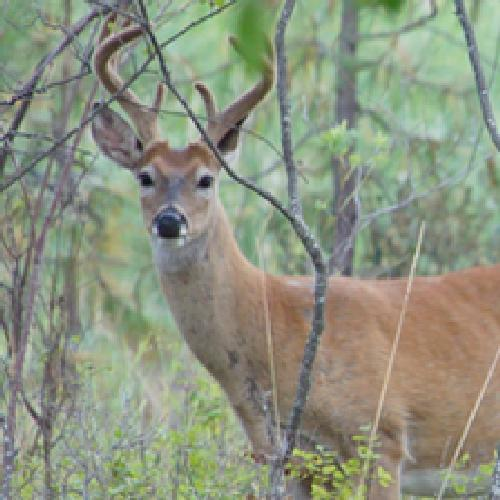

impala, Aepyceros melampus (score = 0.58166)
gazelle (score = 0.17742)
lynx, catamount (score = 0.08309)
dhole, Cuon alpinus (score = 0.07035)
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor (score = 0.03521)


In [8]:
showarray(prep_img('testimages/deer.jpg')/255., size=500)
prediction('testimages/deer.jpg')

<a id='naive'></a>
## Naive feature visualization

This tells us what the network thinks is contained in an image, but we still don't know why. So let's start to look at the features the network has learned to recognize. 

First, we'll define some helper functions to show images, and an input image with a bit of random noise, which is always useful.

In [9]:
# Normalize an image for visualization
def visstd(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

img_noise = np.random.uniform(size=(224,224,3)) + 100.0

The first layer operates directly on the image. It contains a weight tensor taking a 7x7 patch of the image and computing 64 features from it. We can look at the learned weights in this layer to see what kinds of features these are.

conv2d0_w
conv2d1_w
conv2d2_w
mixed3a_1x1_w
mixed3a_3x3_bottleneck_w
mixed3a_3x3_w
mixed3a_5x5_bottleneck_w
mixed3a_5x5_w
mixed3a_pool_reduce_w
mixed3b_1x1_w
mixed3b_3x3_bottleneck_w
mixed3b_3x3_w
mixed3b_5x5_bottleneck_w
mixed3b_5x5_w
mixed3b_pool_reduce_w
mixed4a_1x1_w
mixed4a_3x3_bottleneck_w
mixed4a_3x3_w
mixed4a_5x5_bottleneck_w
mixed4a_5x5_w
mixed4a_pool_reduce_w
mixed4b_1x1_w
mixed4b_3x3_bottleneck_w
mixed4b_3x3_w
mixed4b_5x5_bottleneck_w
mixed4b_5x5_w
mixed4b_pool_reduce_w
mixed4c_1x1_w
mixed4c_3x3_bottleneck_w
mixed4c_3x3_w
mixed4c_5x5_bottleneck_w
mixed4c_5x5_w
mixed4c_pool_reduce_w
mixed4d_1x1_w
mixed4d_3x3_bottleneck_w
mixed4d_3x3_w
mixed4d_5x5_bottleneck_w
mixed4d_5x5_w
mixed4d_pool_reduce_w
mixed4e_1x1_w
mixed4e_3x3_bottleneck_w
mixed4e_3x3_w
mixed4e_5x5_bottleneck_w
mixed4e_5x5_w
mixed4e_pool_reduce_w
mixed5a_1x1_w
mixed5a_3x3_bottleneck_w
mixed5a_3x3_w
mixed5a_5x5_bottleneck_w
mixed5a_5x5_w
mixed5a_pool_reduce_w
mixed5b_1x1_w
mixed5b_3x3_bottleneck_w
mixed5b_3x3_w
mixed

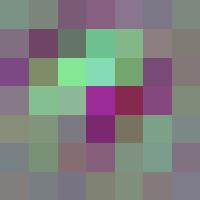

In [10]:
# Uncomment the following line to see all the possible weights
print '\n'.join([op.name[7:] for op in graph.get_operations() if op.name.endswith('w')])
w = T('conv2d0_w')
shape = w.get_shape().as_list()
print shape
feature_id = 14
weights = tf.squeeze(tf.slice(w, [0, 0, 0, feature_id], [-1, -1, -1, 1])).eval()
showarray(visstd(weights), size=200)

If you're trained to look at filter kernels, this may be useful to you. You can also look at what the output of the convolution looks like, by running the first layer on an image.

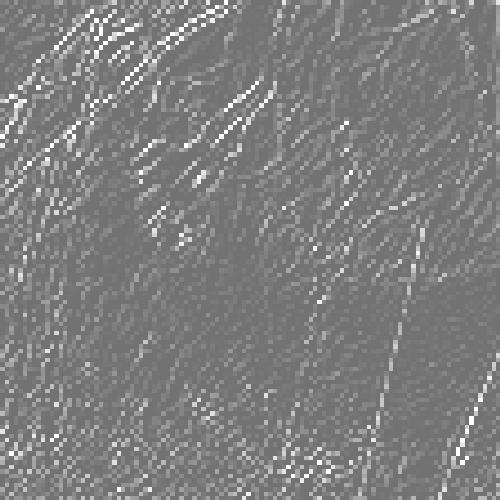

In [11]:
a = T('conv2d0')
feature = tf.squeeze(tf.slice(a, [0, 0, 0, feature_id], [-1, -1, -1, 1]))
img = prep_img('testimages/deer.jpg')
feature = sess.run(feature, {t_input: img})
showarray(visstd(feature), size=500)

Even in the first layer, the weights are not easy to interpret. For all layers except the first, it is almost impossible. We have to find another way of understanding what the network has learned. 

We use a simple visualization technique to show what any given feature looks like: Image space gradient ascent. This works as follows: We pick a feature plane from any layer in the network. This feature plane recognizes the presence of a specific feature in the image. We will try to generate an image that maximizes this feature signal. We start with an image that is just noise, and compute the gradient of the feature signal (averaged over the whole image) with respect to the input image. We then modify the input image to increase the feature signal. This generates an image that this specific network layer thinks is full of whatever feature it is meant to detect.

In [12]:
def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in xrange(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print score,
    clear_output()
    showarray(visstd(img), size=448)

Now we have to pick a layer and a feature channel to visualize. The following cell will enumerate all the available layers.  Refer to the graph above to see where they are. 

Earlier layers (closer to the bottom, i.e. the input) have lower level features, later layers have higher level features. Note that we use layer outputs before applying the ReLU nonlinearity in order to have non-zero gradients for features with negative initial activations (hence the "pre_relu").

In [13]:
# Run this cell if you'd like a list of all layers to pick from
print '\n'.join([op.name[7:] for op in graph.get_operations() if op.name.endswith('pre_relu')])

conv2d0_pre_relu
conv2d1_pre_relu
conv2d2_pre_relu
mixed3a_1x1_pre_relu
mixed3a_3x3_bottleneck_pre_relu
mixed3a_3x3_pre_relu
mixed3a_5x5_bottleneck_pre_relu
mixed3a_5x5_pre_relu
mixed3a_pool_reduce_pre_relu
mixed3b_1x1_pre_relu
mixed3b_3x3_bottleneck_pre_relu
mixed3b_3x3_pre_relu
mixed3b_5x5_bottleneck_pre_relu
mixed3b_5x5_pre_relu
mixed3b_pool_reduce_pre_relu
mixed4a_1x1_pre_relu
mixed4a_3x3_bottleneck_pre_relu
mixed4a_3x3_pre_relu
mixed4a_5x5_bottleneck_pre_relu
mixed4a_5x5_pre_relu
mixed4a_pool_reduce_pre_relu
mixed4b_1x1_pre_relu
mixed4b_3x3_bottleneck_pre_relu
mixed4b_3x3_pre_relu
mixed4b_5x5_bottleneck_pre_relu
mixed4b_5x5_pre_relu
mixed4b_pool_reduce_pre_relu
mixed4c_1x1_pre_relu
mixed4c_3x3_bottleneck_pre_relu
mixed4c_3x3_pre_relu
mixed4c_5x5_bottleneck_pre_relu
mixed4c_5x5_pre_relu
mixed4c_pool_reduce_pre_relu
mixed4d_1x1_pre_relu
mixed4d_3x3_bottleneck_pre_relu
mixed4d_3x3_pre_relu
mixed4d_5x5_bottleneck_pre_relu
mixed4d_5x5_pre_relu
mixed4d_pool_reduce_pre_relu
mixed4e_1x1_p

## Rendering

At this point, we can render one of these layers.

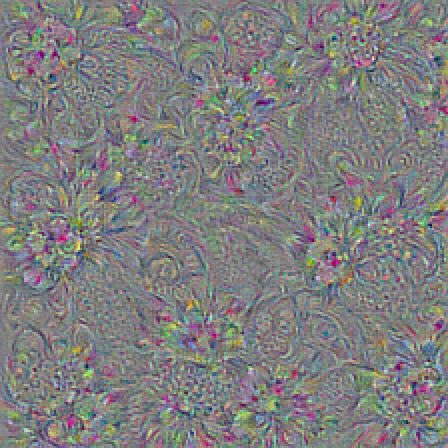

In [14]:
# Pick any internal layer. 
layer = 'mixed4d_3x3_bottleneck_pre_relu'
print '%d channels in layer.' % T(layer).get_shape()[-1] 

# Pick a feature channel to visualize
channel = 139

render_naive(T(layer)[:,:,:,channel])

<a id="multiscale"></a>
## Multiscale image generation

Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale. 

Basically, instead of starting from a random noise image, we start only the first iteration (octave) from random noise, and each octave after we start from the upsampled result of the previous optimization on the smaller image.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [15]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = map(tf.placeholder, argtypes)
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in xrange(0, max(h-sz//2, sz),sz):
        for x in xrange(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

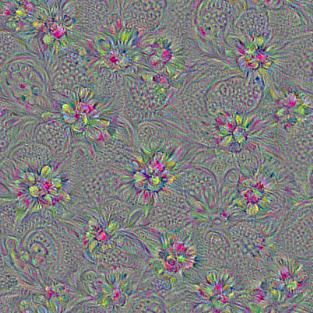

 Octave 1


In [16]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=2, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in xrange(octave_n):
        if octave > 0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in xrange(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print '.',
        clear_output()
        showarray(visstd(img))
        print 'Octave %d' % octave

render_multiscale(T(layer)[:,:,:,channel])

<a id="laplacian"></a>
## Laplacian Pyramid Gradient Normalization

This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the Laplacian pyramid decomposition. We call the resulting technique _Laplacian Pyramid Gradient Normalization_.

We therefore split the image into its various frequency bands by repeatedly blurring it and extracting the highest frequencies by subtracting the blurred image (`lap_split` and `lap_split_n` below). We then normalize each frequency band separately (`normalize_std`), and then merge them back together by basically just adding them up (`lap_merge`).

In [17]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')  # Blurred image -- low frequencies only
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1]) 
        hi = img-lo2 # hi is img with low frequencies removed
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in xrange(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1] # List of images with lower and lower frequencies

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img # Reconstructed image, all frequencies added back together

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n) # Split into frequencies
    tlevels = map(normalize_std, tlevels) # Normalize each frequency band
    out = lap_merge(tlevels) # Put image back together
    return out[0,:,:,:]

We did all this in TensorFlow, so it generated a computation graph that we can inspect.

In [18]:
# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

We now hav everything to render another image. The algorithm is unchanged, except that in each iteration, the gradient image is normalized using the Laplacian normalization graph.

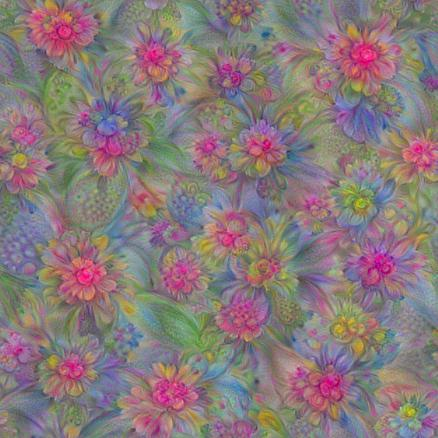

In [19]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # Build the Laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in xrange(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in xrange(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)  # New!
            img += g*step
            print '.',
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

<a id="playing"></a>
## Playing with feature visualizations

We got a nice smooth image using only 10 iterations per octave. In case of running on GPU this takes just a few seconds. Let's try to visualize another channel from the same layer. The network can generate wide diversity of patterns.

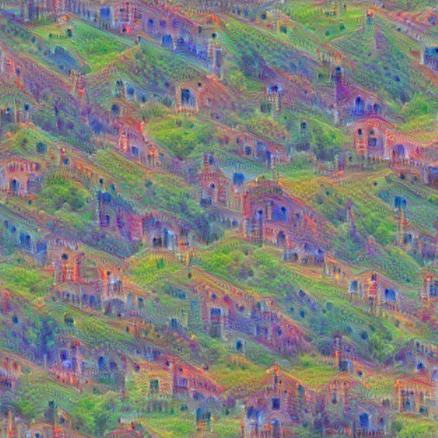

In [20]:
render_lapnorm(T(layer)[:,:,:,65])

Lower layers produce features of lower complexity.

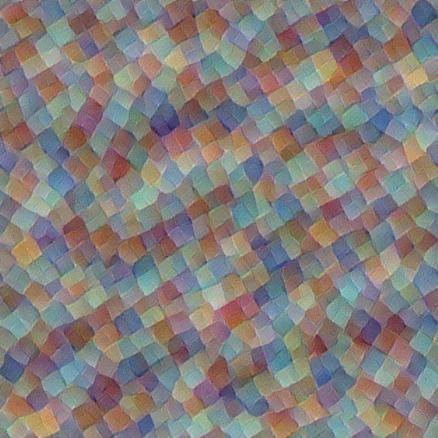

In [21]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

There are many interesting things one may try. For example, optimizing a linear combination of features gives a "mixture" pattern.

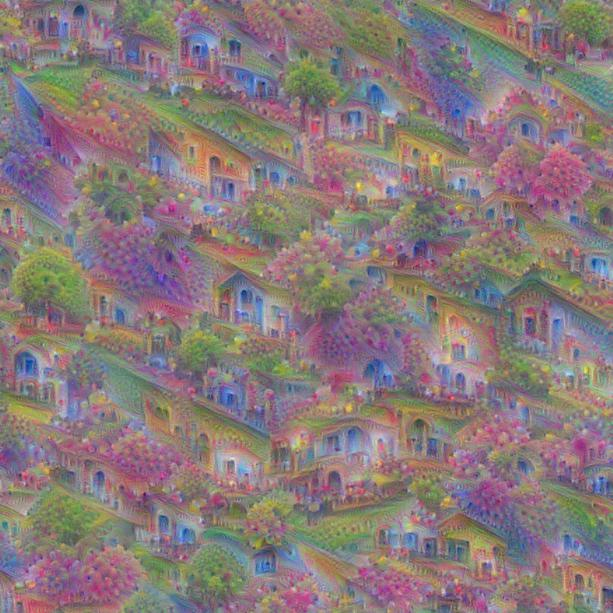

In [22]:
render_lapnorm(T(layer)[:,:,:,65] + T(layer)[:,:,:,139], octave_n=4)

<a id="deepdream"></a>
## DeepDream

Now let's reproduce the [DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with TensorFlow. 


In [23]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # Build the Laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=4))

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in xrange(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in xrange(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in xrange(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print '.',
        clear_output()
        showarray(img/255.0)
        
    return img

Let's load some image and populate it with DogSlugs (in case you've missed them).

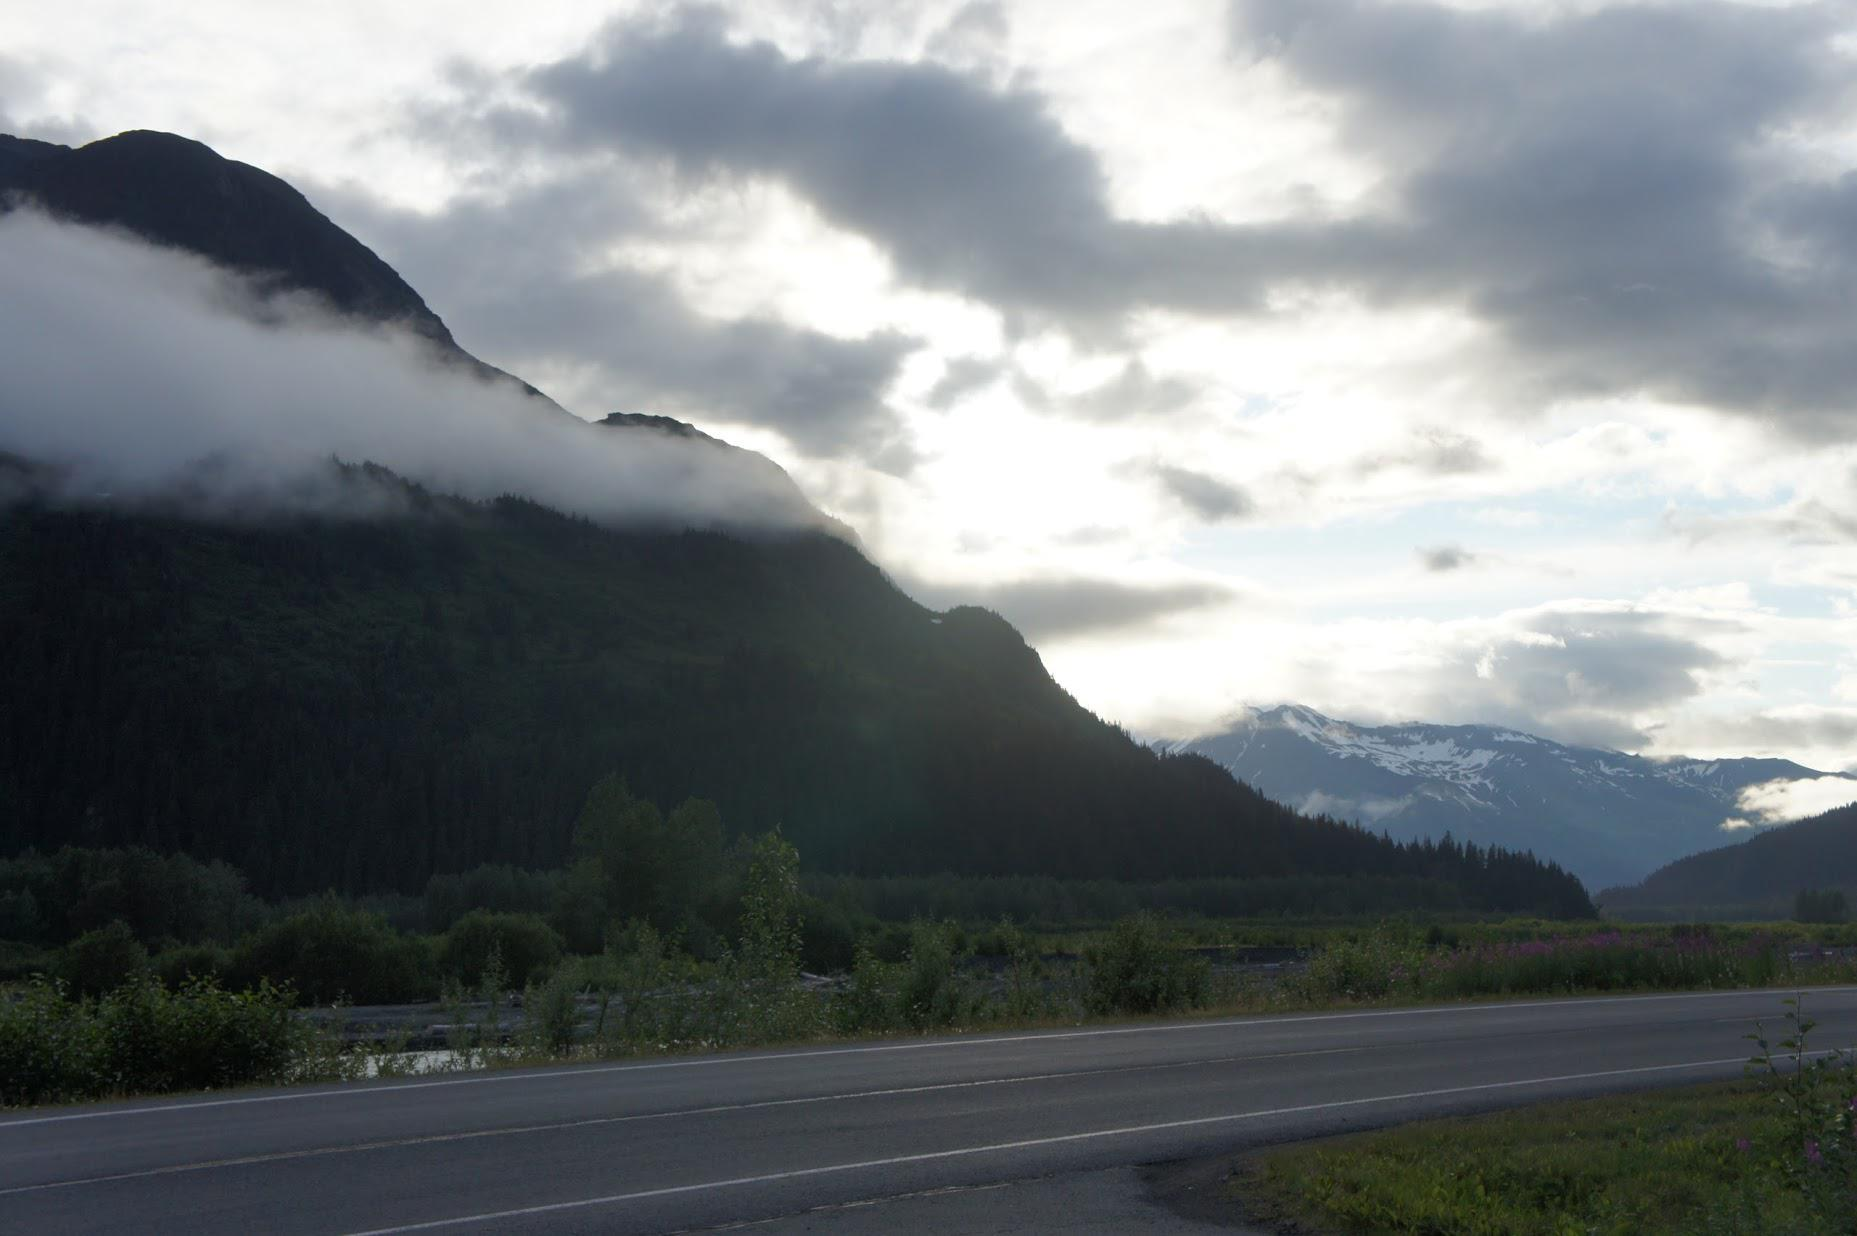

In [24]:
img0 = PIL.Image.open('testimages/mountains.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

Btw., this picture apparently contains a headland. Probably some sort of valley, alp or cliff.

In [25]:
prediction('testimages/mountains.jpg')

valley, vale (score = 0.40127)
alp (score = 0.38135)
volcano (score = 0.08607)
promontory, headland, head, foreland (score = 0.03868)
lakeside, lakeshore (score = 0.03681)


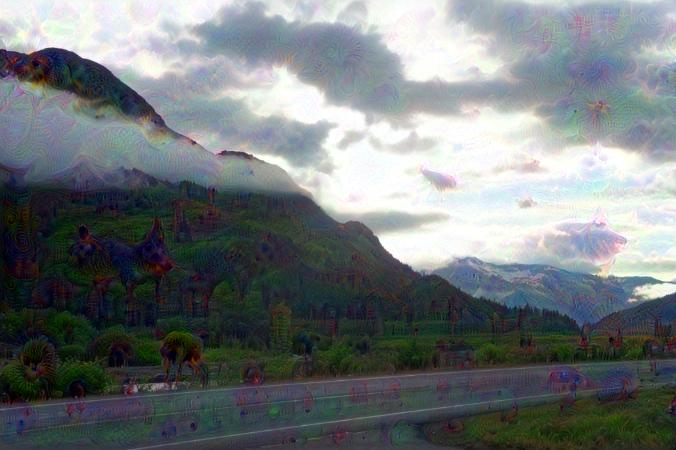

 .

In [ ]:
_ = render_deepdream(tf.square(T('mixed4c')), img0)

Recall how the first parameter to `render_*` was the optimization objecting. In the above case, we are optimizing for `square(mixed4c)`, or in english: "Make an image in which layer `mixed4c` recognizes a lot of stuff. We're not optimizing for a specific feature any more, the network is just trying to overinterpret the image best it can.

The network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

However, we can force it to dream about a specific topic by changing the objective function to a specific feature or a combination of specific features. More castles!

In [ ]:
_ = render_deepdream(T(layer)[:,:,:,65], img0)

Now, have fun! Upload your own images, and make the computer dream about the prettiest, creepiest, or most surreal things.

Don't hesitate to use higher resolution inputs (also increase the number of octaves)! Here is an [example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg) of running the flower dream over a bigger image.

The DeepDream [notebook](https://github.com/google/deepdream/blob/master/dream.ipynb) contains code with many more options to explore. You can guide the dreaming towards a specific image, or repeat it endlessly to produce dreamier dreams. If you're very patient, you can even make videos.

In [ ]:
frame = img0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(100):
    frame = render_deepdream(tf.square(T('mixed4c')), img0=frame)
    img = PIL.Image.fromarray(np.uint8(np.clip(frame, 0, 255)))
    img.save("dream-%04d.jpg"%i)
    # Zoom in while maintaining size
    img = img.resize(np.int32([w*(1+s), h*(1+s)]))
    t, l = np.int32([h*(1+s) * s / 2, w*(1+s) * s / 2])
    img = img.crop([l, t, w-l, h-t])
    img.load()
    print img.size
    frame = np.float32(img)

<a id="fun"></a>
## More Fun

For more more things to do, check out the [TensorFlow tutorials](http://tensorflow.org/tutorials). If you enjoyed this tutorial, you will probably like the [retraining example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/image_retraining).

In this tutorial, we used the Inception v3, trained on imagenet. We have recently released the [source code to Inception](https://github.com/tensorflow/models/tree/master/inception), allowing you to train an Inception network on your own data.